# Prototype 02 
## Experiment 01
## --- Setup ---

In [1]:
executed_yet = False

In [2]:
import os

if not executed_yet:
    executed_yet = True
    original_working_directory_path = os.getcwd()
    os.chdir(os.path.join(original_working_directory_path, "../.."))
    root_working_directory_path =  os.getcwd()
    
print(f'Original working directory: {original_working_directory_path}')
print(f'Current working directory: {root_working_directory_path}')

Original working directory: /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_02
Current working directory: /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


## --- Dependencies ---

In [3]:
# Standard Dependencies
import sys
import os
import numpy as np
from tabulate import tabulate
import torch
from time import time
import torch.nn as nn

/Users/jankreischer/opt/anaconda3/envs/FedRL-for-IT-Sec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Global Dependencies
from src.autoencoder import AutoEncoder, RMSELoss
from src.custom_types import Behavior, Execution, Evaluation, MTDTechnique, actions, mitigated_by
from src.data_provider import DataProvider
from src.functions import split_training_data, split_data, calculate_balance_metrics
from src.sampling_probabilities import unit_sampling_probabilities, regular_sampling_probabilities, inverted_sampling_probabilities, \
    weak_client_exclusive_sampling_probabilities_01, weak_client_exclusive_sampling_probabilities_02, \
    medium_client_exclusive_sampling_probabilities_01, medium_client_exclusive_sampling_probabilities_02, \
    strong_client_exclusive_sampling_probabilities_01, strong_client_exclusive_sampling_probabilities_02

In [5]:
from prototypes.prototype_02.deep_q_network import DeepQNetwork
from prototypes.prototype_02.agent import Agent
from prototypes.prototype_02.client import Client
from prototypes.prototype_02.server import Server
from prototypes.prototype_02.experiment import Experiment

In [6]:
rl_training_data, test_data, _ = DataProvider.get_scaled_train_test_split_one(scaling_minmax=True, scale_normal_only=True)
normal_data = rl_training_data[Behavior.NORMAL]
threshold = int(len(normal_data) * 0.5)

rl_training_data[Behavior.NORMAL] = normal_data[:threshold]

ae_training_data = normal_data[threshold:]  # use remaining samples for autoencoder
ae_training_x, ae_valid_x = split_data(ae_training_data)

N_FEATURES = normal_data.shape[1] -1
flattend_test_data = np.empty([0, N_FEATURES+1])
for behavior, behavior_data in test_data.items():
    if behavior == Behavior.NORMAL:
        NR_SAMPLES = 2800
        behavior_data[:, -1] =  0
    else:
        NR_SAMPLES = 400
        behavior_data[:, -1] = 1
    #y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * NR_SAMPLES)
    
    flattend_test_data = np.concatenate((flattend_test_data, behavior_data[:NR_SAMPLES]), axis=0)

ae_test_x = flattend_test_data[:,:-1]
ae_test_y = flattend_test_data[:,-1].astype(int)

rl_training_data_strides = split_training_data(rl_training_data, 10)

In [7]:
autoencoder = AutoEncoder(ae_valid_x, ae_test_x, ae_test_y, rl_training_data, n_hidden_1=64, n_hidden_2=16, activation_function=nn.GELU())
autoencoder.pretrain(ae_training_x, optimizer=torch.optim.Adam(autoencoder.parameters(), lr=1e-4,  weight_decay=0.01), loss_function=RMSELoss(), num_epochs=50, batch_size=64, verbose=False)

In [8]:
autoencoder.evaluate(n_std=5, tablefmt='latex_raw')

\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 95.37\%    & \notCalculated & \notCalculated & \notCalculated &        4166 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        5276 \\
 ROOTKIT\_BDVL            & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2599 \\
 ROOTKIT\_BEURK           & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        3852 \\
 CNC\_THETICK             & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        4093 \\
 CNC\_BACKDOOR\_JAKORITAR & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2076 \\
 CNC\_OPT1                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        3026 \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2151 \\

In [65]:
def run_sample_distribution_experiment(experiment_id, experiment_version, training_data_strides, sampling_probabilities_01, sampling_probabilities_02, nr_clients=10, nr_rounds=30, nr_episodes_per_round=100, evaluate_local_clients=False):
    experiment = Experiment(base_path=original_working_directory_path, experiment_id=experiment_id, experiment_version=experiment_version)
    experiment_path = experiment.get_experiment_path()

    # HYPERPARAMETER for State Anomaly Detector
    N_STD = 2.5
    N_STATE_SAMPLES = 1

    # HYPERPARAMETER for Federated Learning
    NR_CLIENTS = nr_clients
    NR_ROUNDS = nr_rounds
    NR_EPISODES_PER_ROUND = nr_episodes_per_round
    NR_EPISODES_PER_CLIENT = NR_ROUNDS * NR_EPISODES_PER_ROUND

    # DQN Architecture Hyperparameter
    N_ACTIONS = len(MTDTechnique)
    N_HIDDEN_1 = 128
    N_HIDDEN_2 = 128
    N_HIDDEN_3 = 16
    N_FEATURES = normal_data.shape[1] -1

    # DQN Training Hyperparameter
    GAMMA = 0.5 #0.99 # discount factor for future rewards
    LR = 1e-3
    BATCH_SIZE = 32
    TARGET_UPDATE_FREQ = NR_EPISODES_PER_ROUND - 1
    BUFFER_SIZE = 500
    MIN_REPLAY_SIZE = 100

    #SCHEDULER = 
    LOSS=nn.MSELoss()
    L2 = 0.01


    # HYPERPARAMETER for Epsilon Delta Strategy
    EPSILON_START = 1.0
    EPSILON_DEC = 1/(NR_EPISODES_PER_CLIENT*0.8)
    print(EPSILON_DEC)
    EPSILON_END = 0.01


    calculate_balance_metrics(sampling_probabilities_01, sampling_probabilities_02, NR_EPISODES_PER_CLIENT)

    deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
    global_agent = Agent(0, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=None, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
    server = Server(global_agent, test_data, autoencoder, experiment_id, experiment_path)

    clients = []
    for i in range(NR_CLIENTS):
        entity_id = i + 1
        if entity_id % 2 == 0:
            SAMPLING_PROBABILITIES = sampling_probabilities_01
        else:
            SAMPLING_PROBABILITIES = sampling_probabilities_02
            
        environment = Environment(entity_id, training_data_strides[i], state_interpreter=autoencoder, n_state_samples=N_STATE_SAMPLES, sampling_probabilities=SAMPLING_PROBABILITIES , verbose=False)
        deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
        optimizer = torch.optim.Adam(deep_q_network.parameters(), lr=LR,  weight_decay=L2, amsgrad=True)
        agent = Agent(entity_id, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=optimizer, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
        client = Client(entity_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)
        server.add_client(client)

    evaluations = [Evaluation.GLOBAL_PERFORMANCE_EVALUATION]
    if evaluate_local_clients:
        print("Evaluating local clients as well")
        evaluations.append(Evaluation.LOCAL_PERFORMANCE_EVALUATION)
    experiment.execute(server, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, evaluations=evaluations, evaluation_frequency=1)
    return experiment

---
## Scenario 00 (Baseline)
1 Client trained with unit sampling probabilities

In [66]:
e1v0 = run_sample_distribution_experiment(1, 0, rl_training_data_strides, unit_sampling_probabilities, unit_sampling_probabilities, 1, 30, 100, False)

0.0004166666666666667
Dataset Balance Metrics: MID=0.0 & WCS=1.0
DeepQNetwork(
  (L1): Linear(in_features=86, out_features=128, bias=True)
  (L2): Linear(in_features=128, out_features=128, bias=True)
  (L3): Linear(in_features=128, out_features=16, bias=True)
  (L4): Linear(in_features=128, out_features=4, bias=True)
  (loss): MSELoss()
)
=== STARTING EXPERIMENT 1.0 ===

Training each of the 1 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.
>>> SERVER TRAINING ROUND 1/30 <<<
Evaluating round 1/30
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |       0    | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          18

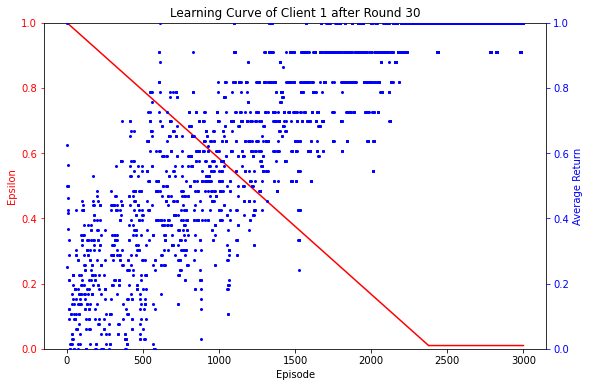

In [67]:
e1v0.show_learning_curves()

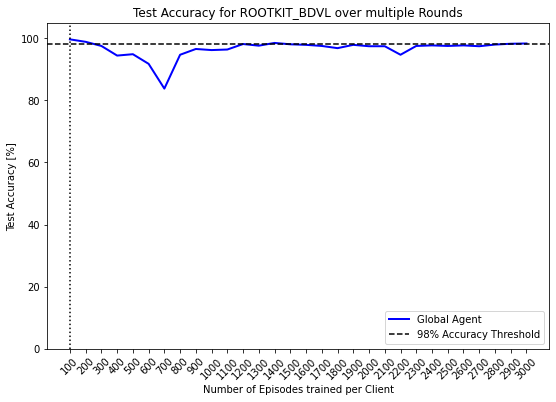

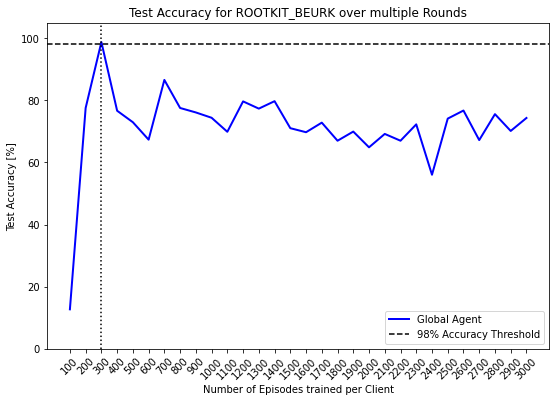

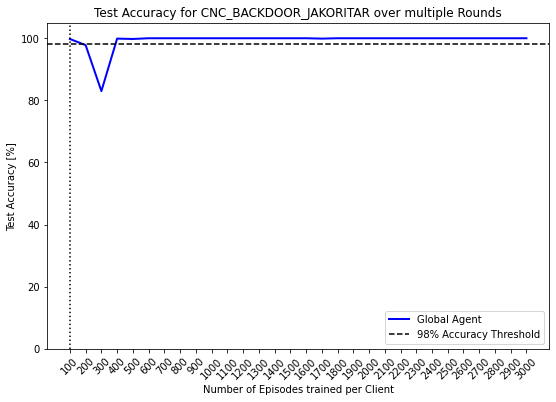

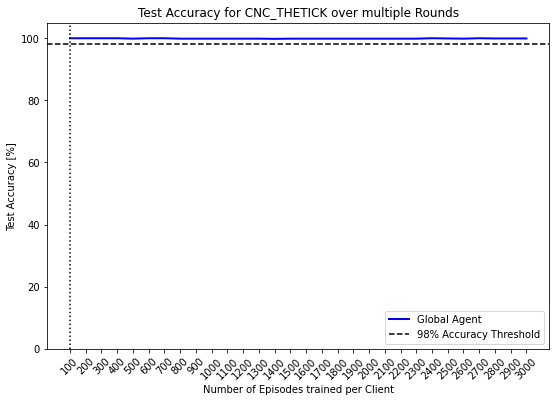

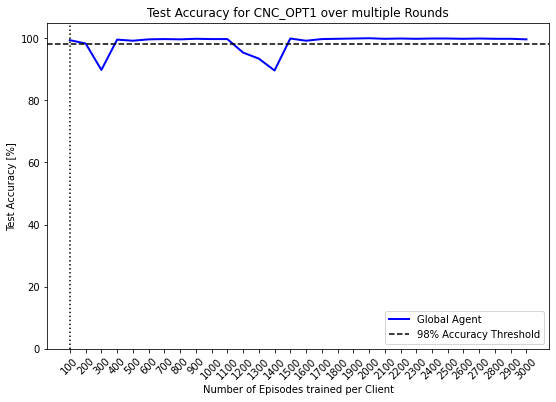

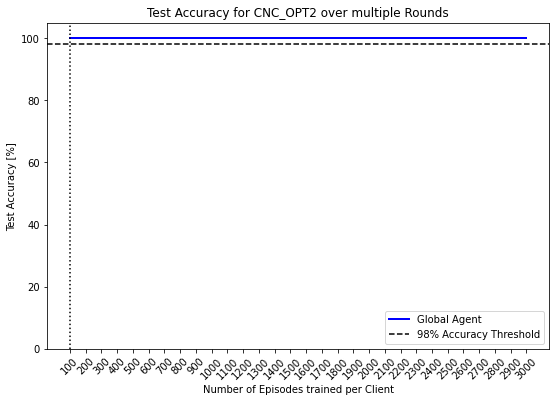

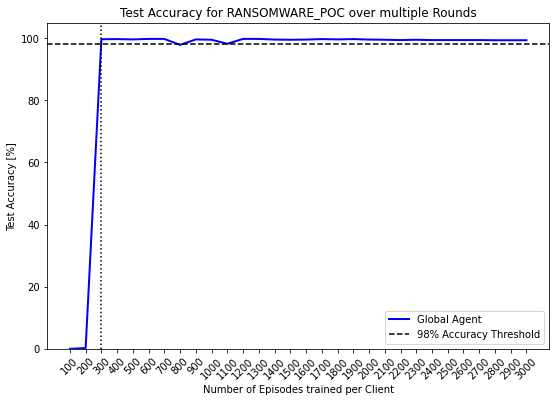

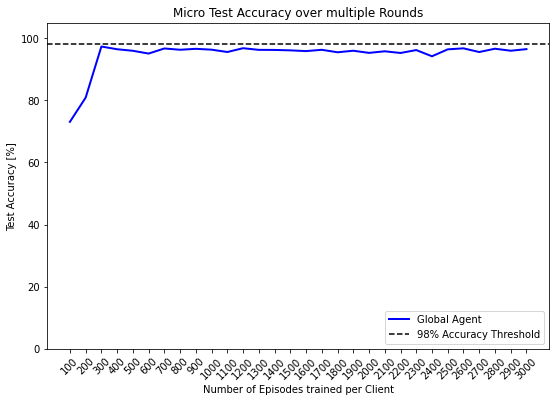

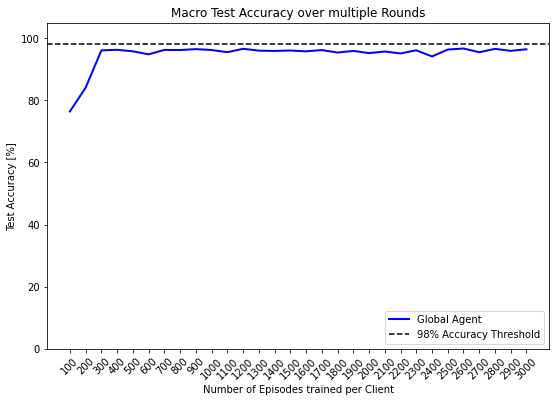

In [68]:
e1v0.show_experiment_graphs(y_threshold=98, show_individual_clients=False)

---
## Scenario 01 (Globally and Locally Class Balanced)

In [35]:
e1v1 = run_sample_distribution_experiment(1, 1, rl_training_data_strides, unit_sampling_probabilities, unit_sampling_probabilities, 10, 30, 100, False)

0.0004166666666666667
Dataset Balance Metrics: MID=0.0 & WCS=1.0
DeepQNetwork(
  (L1): Linear(in_features=86, out_features=128, bias=True)
  (L2): Linear(in_features=128, out_features=128, bias=True)
  (L3): Linear(in_features=128, out_features=16, bias=True)
  (L4): Linear(in_features=128, out_features=4, bias=True)
  (loss): MSELoss()
)
=== STARTING EXPERIMENT 1.0 ===

Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.
>>> SERVER TRAINING ROUND 1/30 <<<
Evaluating round 1/30
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |       0.21 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1

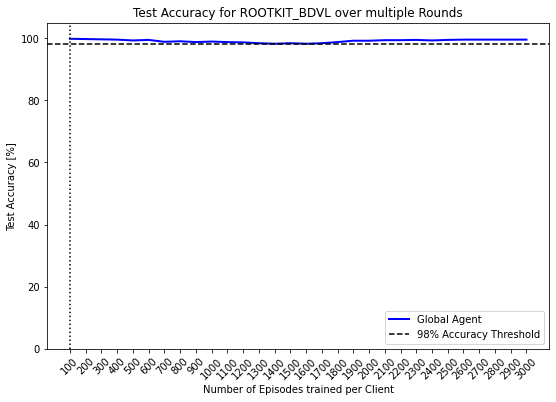

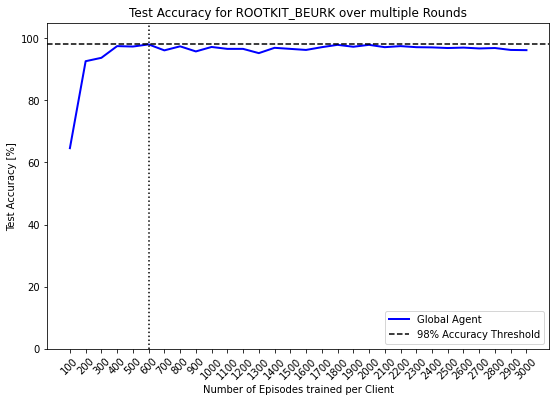

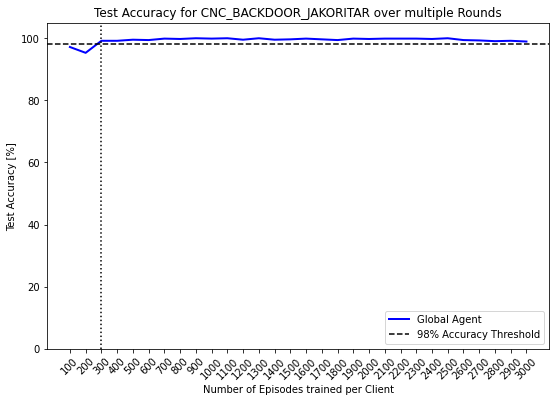

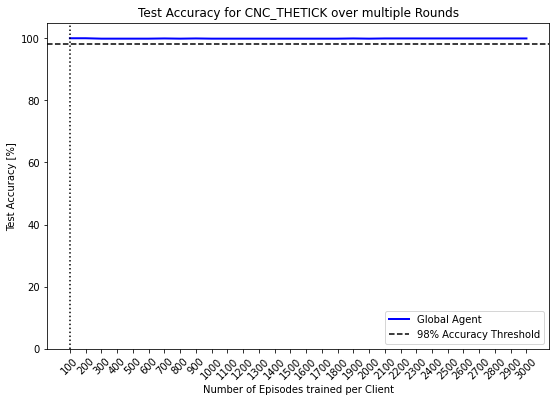

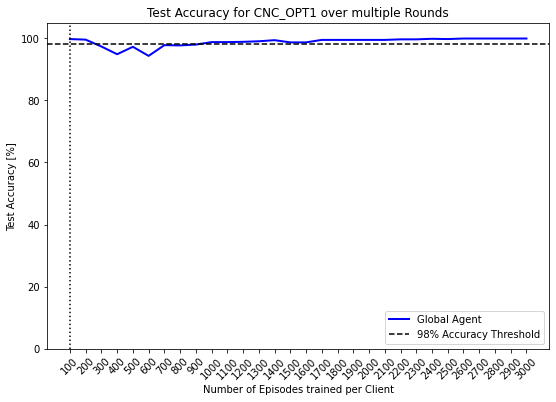

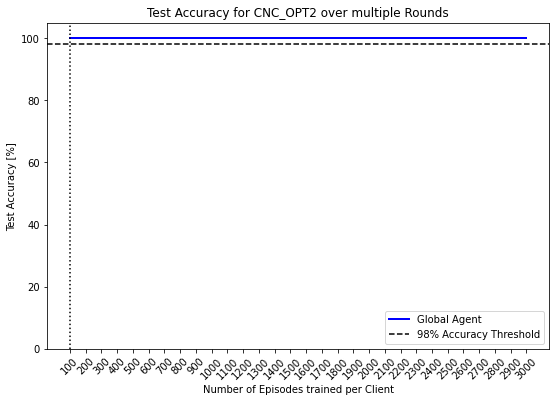

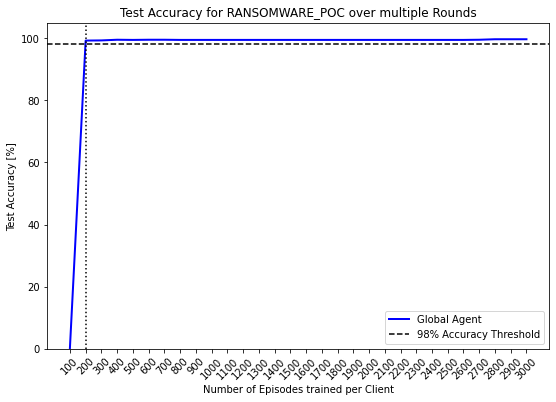

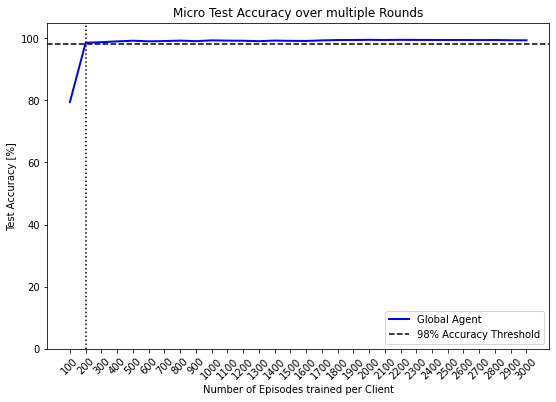

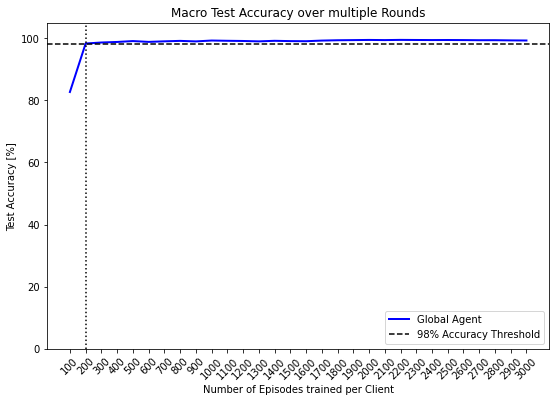

In [41]:
e1v1.show_experiment_graphs(y_threshold=98, show_individual_clients=False)

---
## Scenario 02 (Globally Imbalanced and Locally Class Balanced)

In [52]:
e1v2 = run_sample_distribution_experiment(1, 2, rl_training_data_strides, regular_sampling_probabilities, regular_sampling_probabilities, 1, 30, 100, False)

0.0004166666666666667
Dataset Balance Metrics: MID=0.0267 & WCS=1.0
DeepQNetwork(
  (L1): Linear(in_features=86, out_features=128, bias=True)
  (L2): Linear(in_features=128, out_features=128, bias=True)
  (L3): Linear(in_features=128, out_features=16, bias=True)
  (L4): Linear(in_features=128, out_features=4, bias=True)
  (loss): MSELoss()
)
=== STARTING EXPERIMENT 1.2 ===

Training each of the 1 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.
>>> SERVER TRAINING ROUND 1/30 <<<
Evaluating round 1/30
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |       0.05 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |         

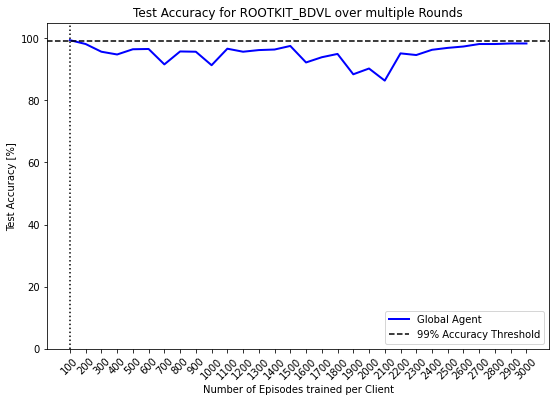

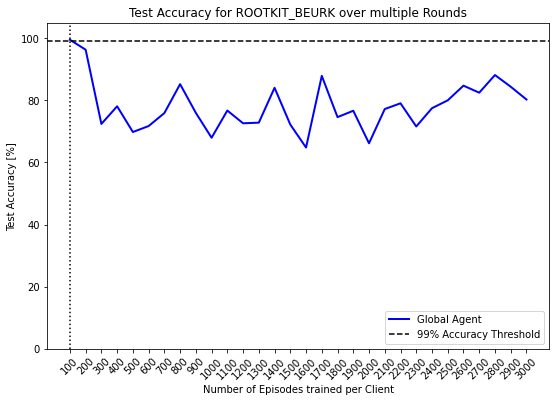

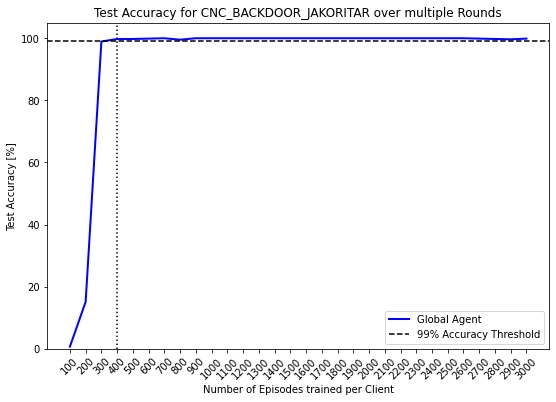

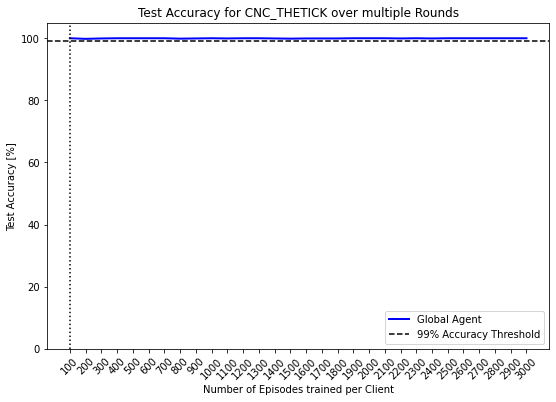

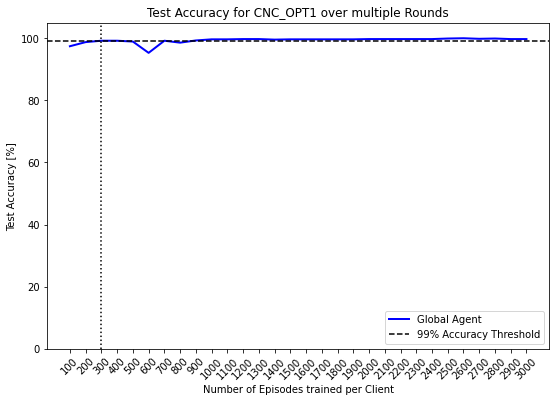

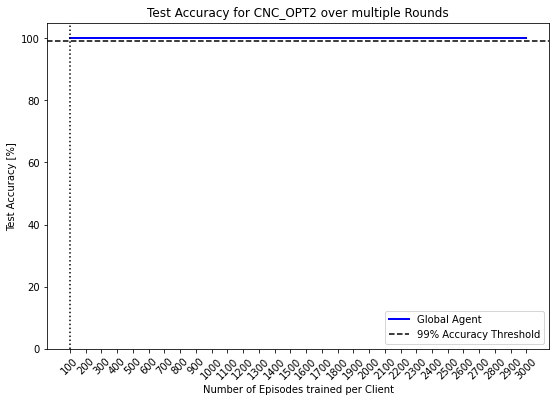

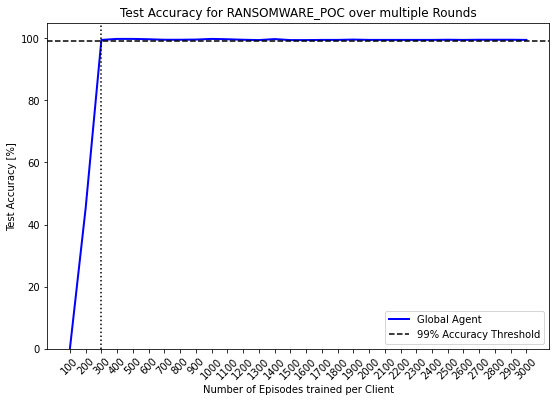

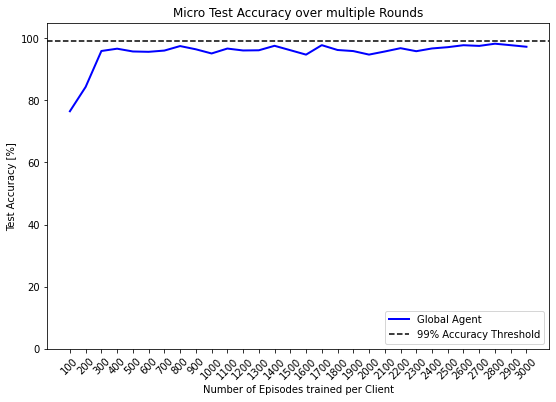

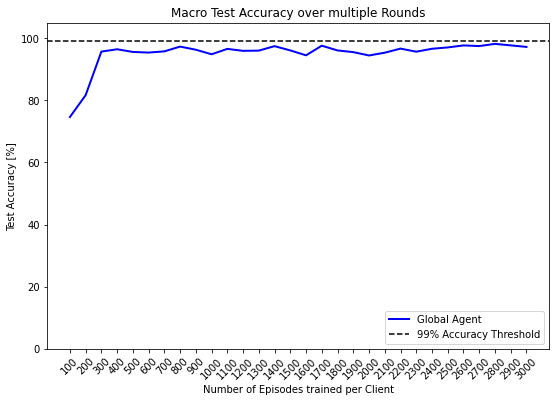

In [69]:
e1v2.show_experiment_graphs(y_threshold=99, show_individual_clients=False)

---
## Scenario 03 (Globally Balanced but Locally Class Imbalanced)

In [70]:
e1v3 = run_sample_distribution_experiment(1, 3, rl_training_data_strides, regular_sampling_probabilities, inverted_sampling_probabilities, 1, 30, 100, False)

0.0004166666666666667
Dataset Balance Metrics: MID=0.0 & WCS=0.9516
DeepQNetwork(
  (L1): Linear(in_features=86, out_features=128, bias=True)
  (L2): Linear(in_features=128, out_features=128, bias=True)
  (L3): Linear(in_features=128, out_features=16, bias=True)
  (L4): Linear(in_features=128, out_features=4, bias=True)
  (loss): MSELoss()
)
=== STARTING EXPERIMENT 1.3 ===

Training each of the 1 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.
>>> SERVER TRAINING ROUND 1/30 <<<
Evaluating round 1/30
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |      99.41 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |         

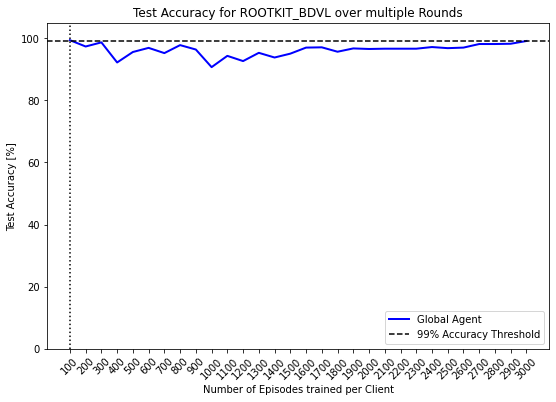

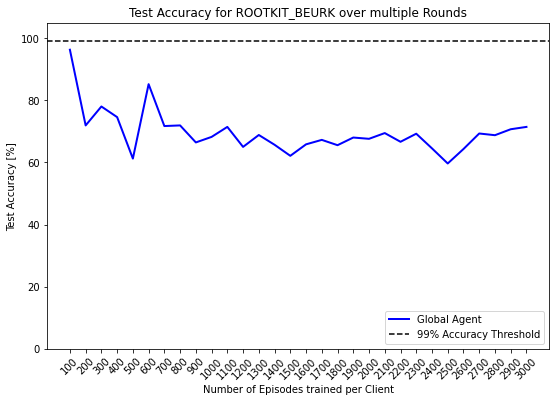

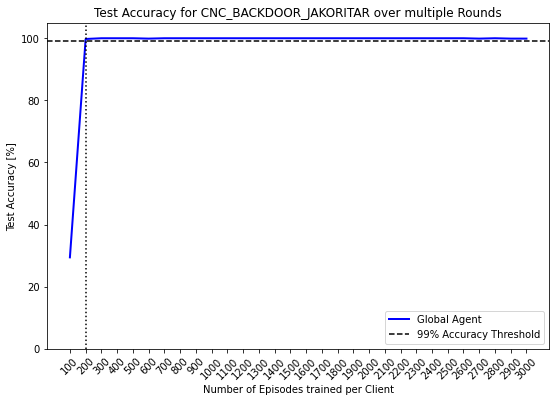

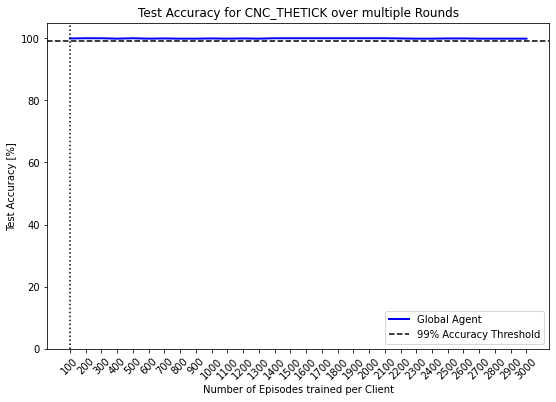

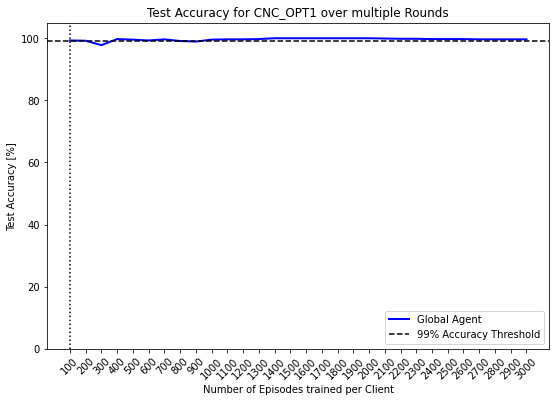

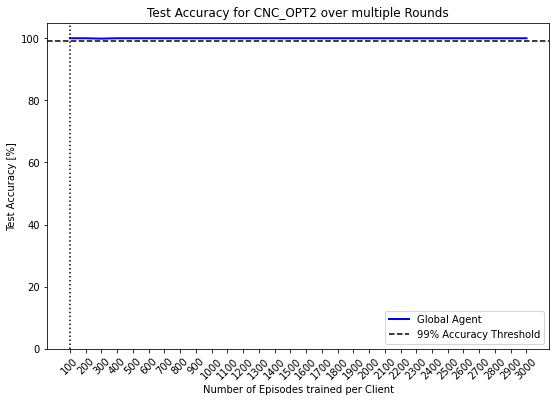

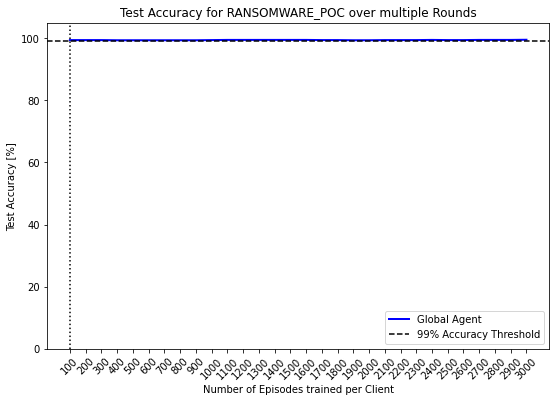

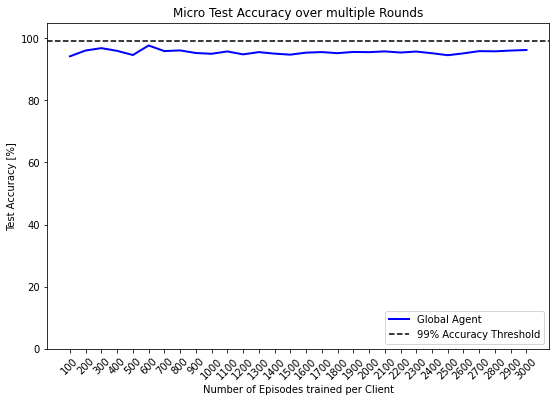

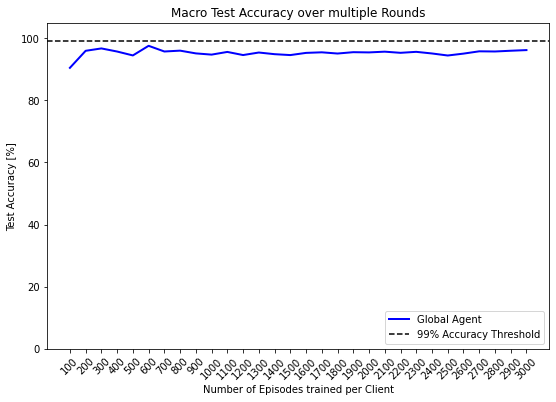

In [71]:
e1v3.show_experiment_graphs(y_threshold=99, show_individual_clients=False)

---
## Scenario 04 (Globally and Locally Class Imbalanced)

In [72]:
e1v4 = run_sample_distribution_experiment(1, 4, rl_training_data_strides, unit_sampling_probabilities, regular_sampling_probabilities, 1, 30, 100, False)

0.0004166666666666667
Dataset Balance Metrics: MID=0.0066 & WCS=0.9878
DeepQNetwork(
  (L1): Linear(in_features=86, out_features=128, bias=True)
  (L2): Linear(in_features=128, out_features=128, bias=True)
  (L3): Linear(in_features=128, out_features=16, bias=True)
  (L4): Linear(in_features=128, out_features=4, bias=True)
  (loss): MSELoss()
)
=== STARTING EXPERIMENT 1.4 ===

Training each of the 1 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.
>>> SERVER TRAINING ROUND 1/30 <<<
Evaluating round 1/30
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |      99.46 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |      

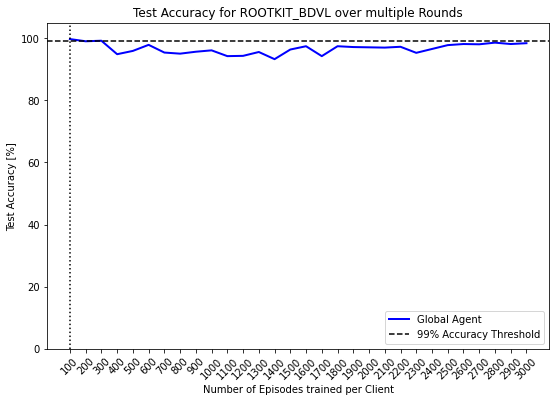

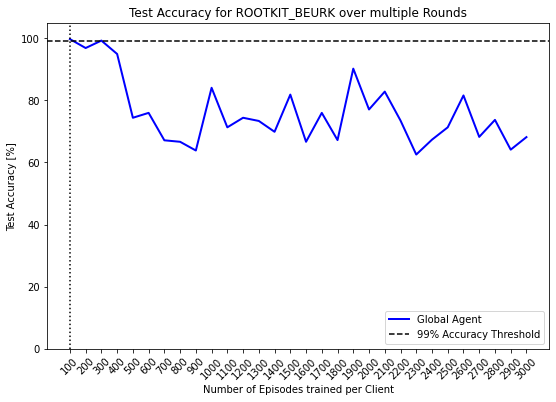

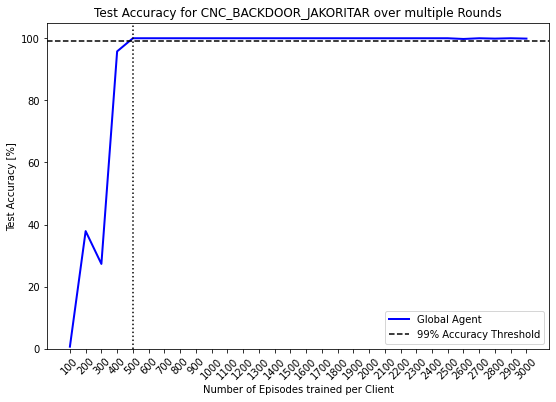

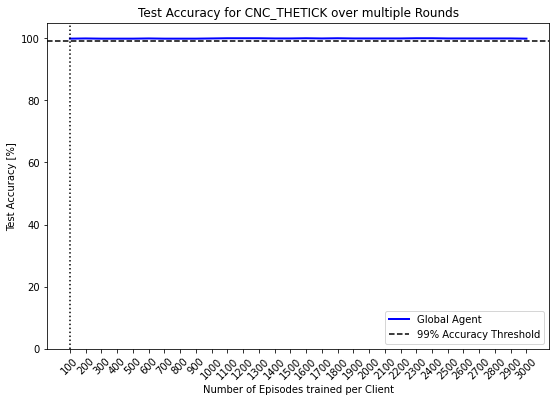

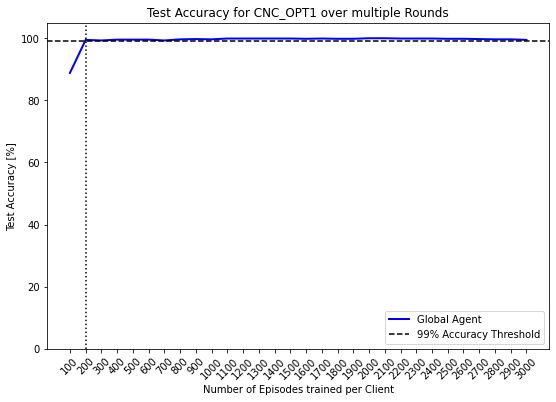

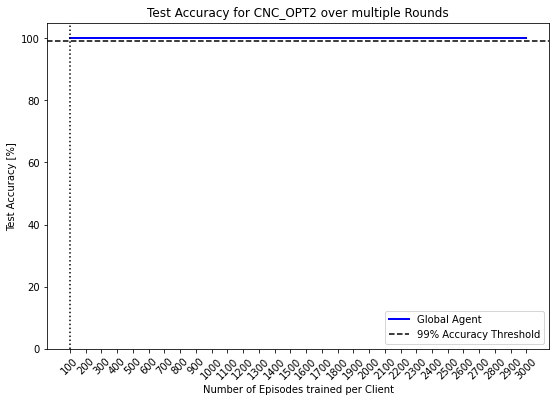

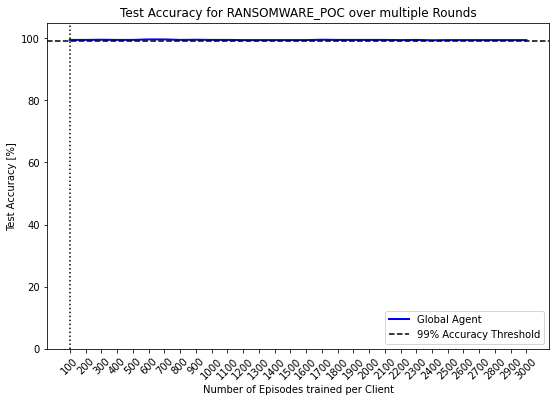

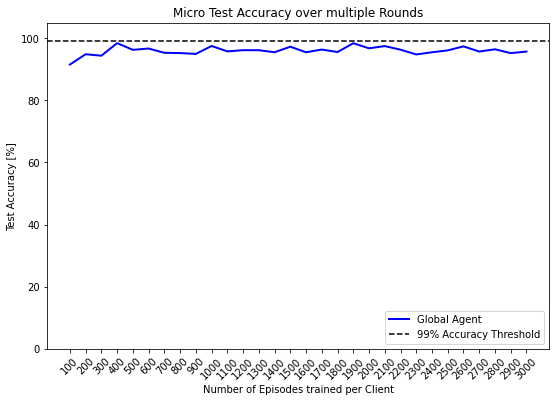

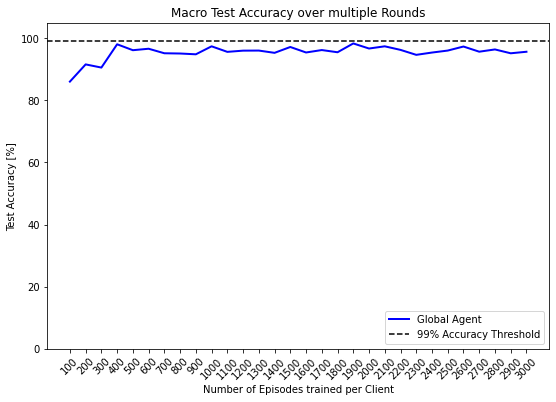

In [73]:
e1v4.show_experiment_graphs(y_threshold=99, show_individual_clients=False)

---
## Scenario 05 (Weak Client Exclusive Class Setting)

In [49]:
e1v5 = run_sample_distribution_experiment(1, 5, rl_training_data_strides, weak_client_exclusive_sampling_probabilities_01, weak_client_exclusive_sampling_probabilities_02, 10, 30, 100, False)

0.0004166666666666667
Dataset Balance Metrics: MID=0.0198 & WCS=0.9574
DeepQNetwork(
  (L1): Linear(in_features=86, out_features=128, bias=True)
  (L2): Linear(in_features=128, out_features=128, bias=True)
  (L3): Linear(in_features=128, out_features=16, bias=True)
  (L4): Linear(in_features=128, out_features=4, bias=True)
  (loss): MSELoss()
)
=== STARTING EXPERIMENT 1.5 ===

Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.
>>> SERVER TRAINING ROUND 1/30 <<<
Evaluating round 1/30
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |       0    | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |     

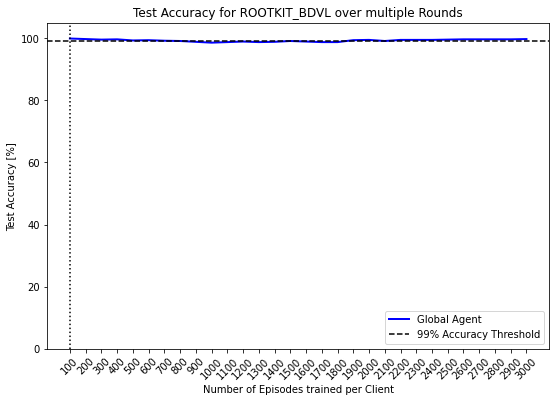

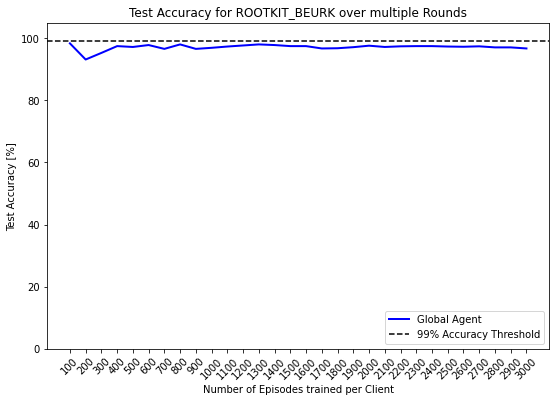

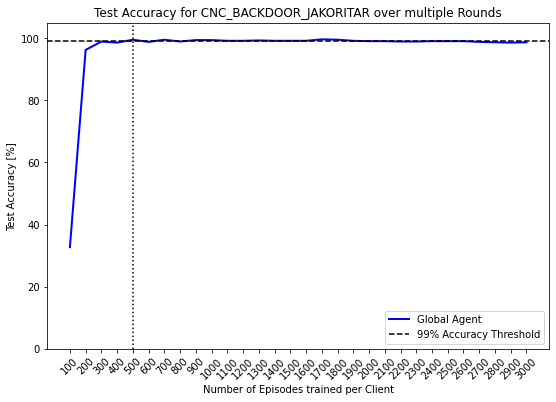

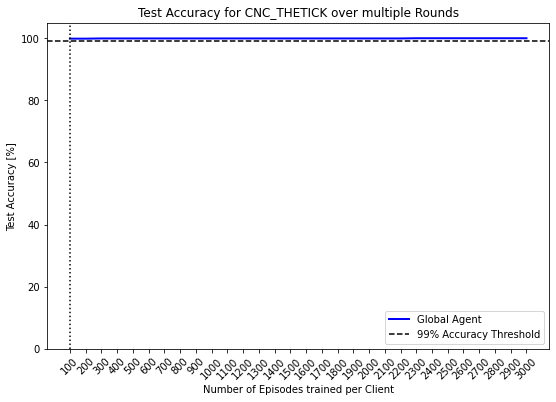

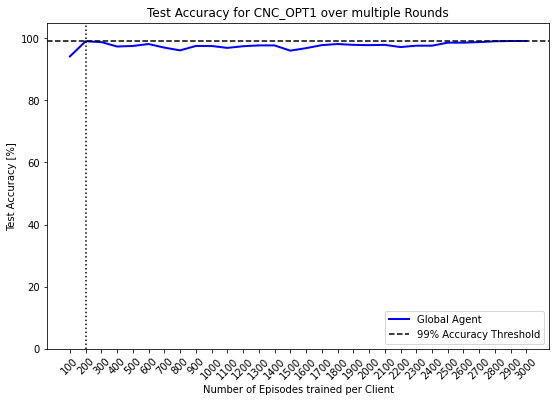

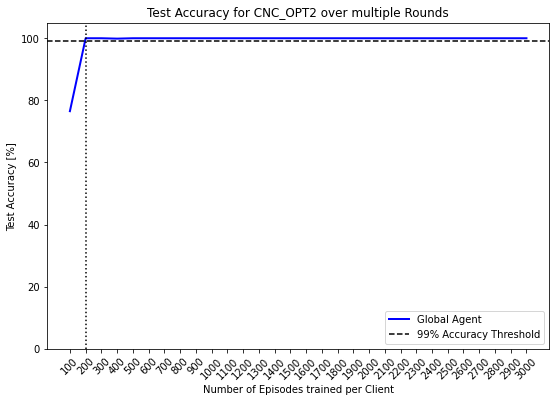

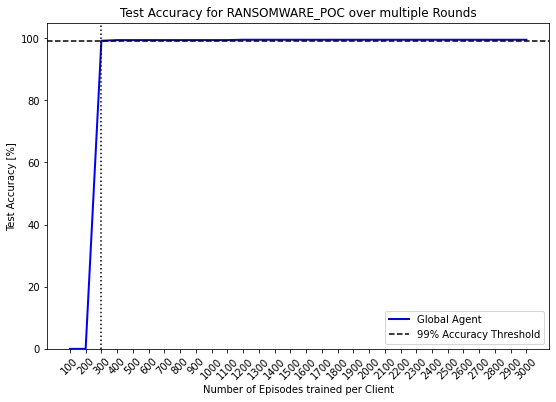

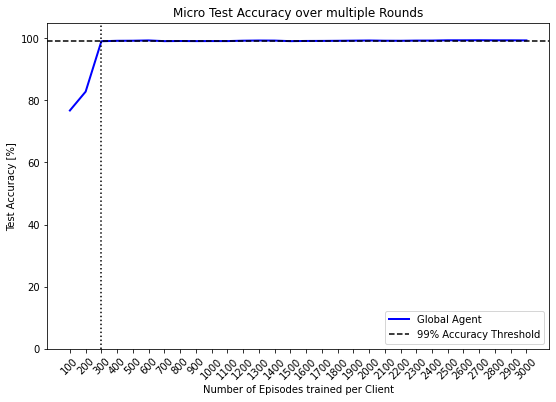

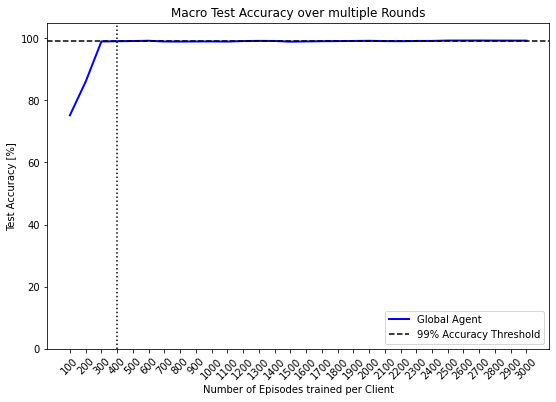

In [75]:
e1v5.show_experiment_graphs(y_threshold=99, show_individual_clients=False)

---
## Scenario 06 (Medium Client Exclusive Class Setting)

In [46]:
e1v6 = run_sample_distribution_experiment(1, 6, rl_training_data_strides, medium_client_exclusive_sampling_probabilities_01, medium_client_exclusive_sampling_probabilities_02, 10, 30, 100, False)

0.0004166666666666667
Dataset Balance Metrics: MID=0.0304 & WCS=0.8944
DeepQNetwork(
  (L1): Linear(in_features=86, out_features=128, bias=True)
  (L2): Linear(in_features=128, out_features=128, bias=True)
  (L3): Linear(in_features=128, out_features=16, bias=True)
  (L4): Linear(in_features=128, out_features=4, bias=True)
  (loss): MSELoss()
)
=== STARTING EXPERIMENT 1.6 ===

Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.
>>> SERVER TRAINING ROUND 1/30 <<<
Evaluating round 1/30
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |       0    | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |     

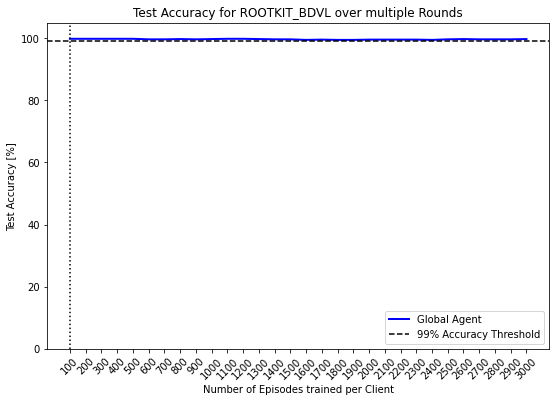

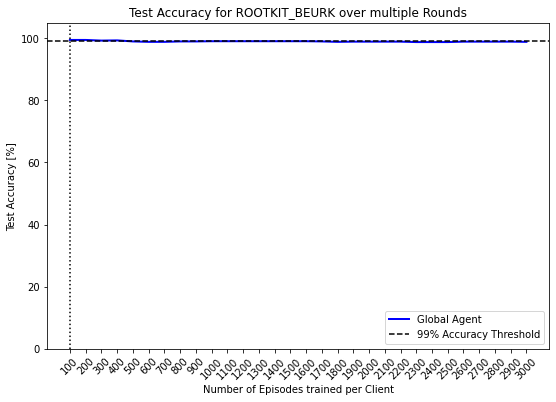

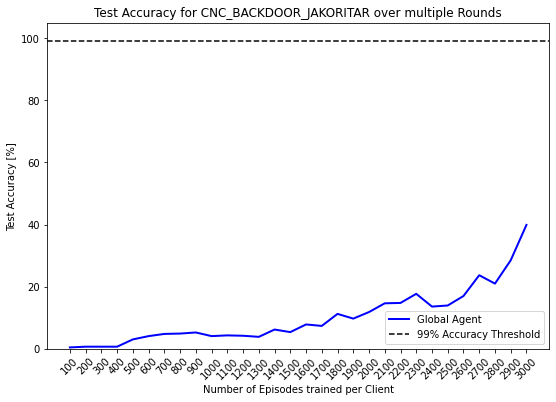

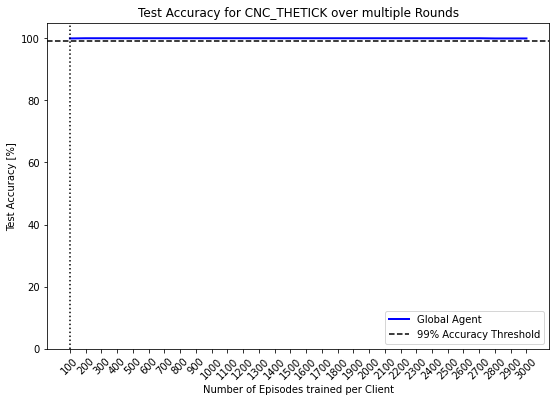

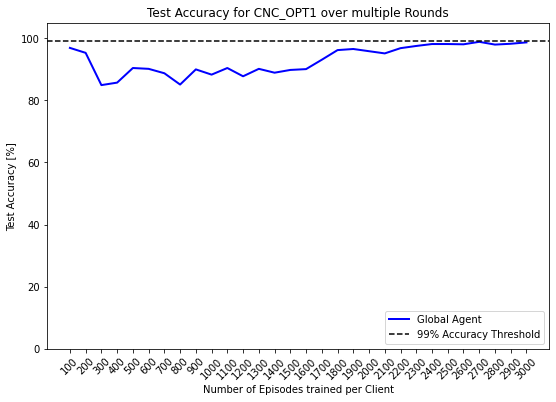

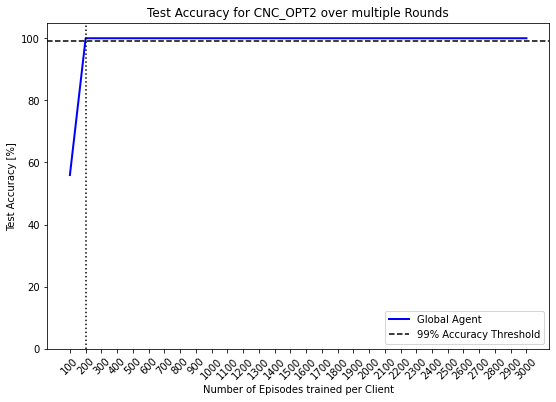

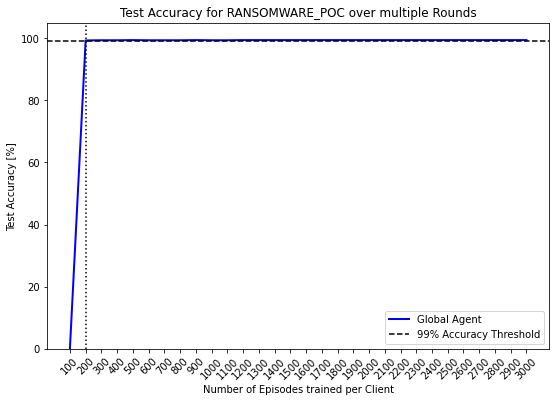

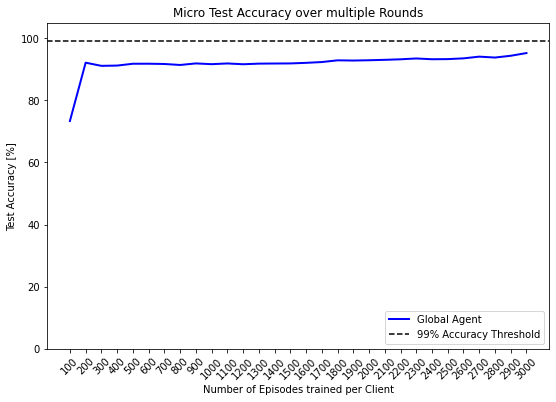

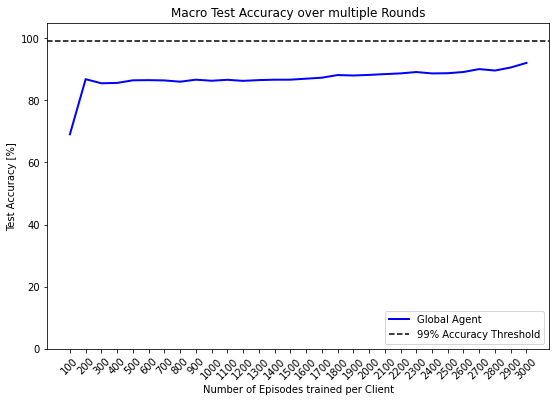

In [76]:
e1v6.show_experiment_graphs(y_threshold=99, show_individual_clients=False)

---
## Scenario 07 (Strong Client Exclusive Class Setting)

In [43]:
e1v7 = run_sample_distribution_experiment(1, 7, rl_training_data_strides, strong_client_exclusive_sampling_probabilities_01, strong_client_exclusive_sampling_probabilities_02, 10, 30, 100, False)

0.0004166666666666667
Dataset Balance Metrics: MID=0.0053 & WCS=0.7053
DeepQNetwork(
  (L1): Linear(in_features=86, out_features=128, bias=True)
  (L2): Linear(in_features=128, out_features=128, bias=True)
  (L3): Linear(in_features=128, out_features=16, bias=True)
  (L4): Linear(in_features=128, out_features=4, bias=True)
  (loss): MSELoss()
)
=== STARTING EXPERIMENT 1.7 ===

Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.
>>> SERVER TRAINING ROUND 1/30 <<<
Evaluating round 1/30
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |      99.3  | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |     

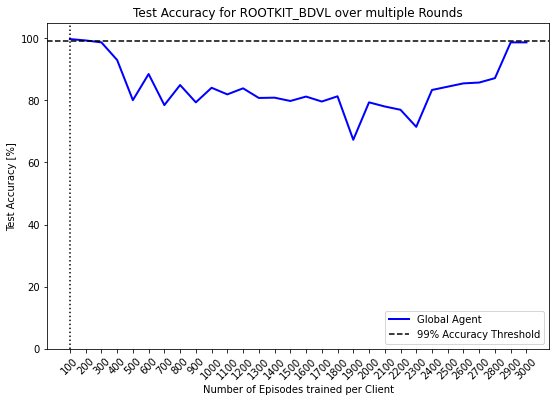

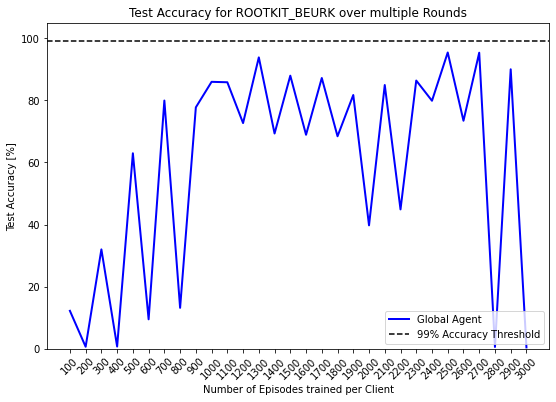

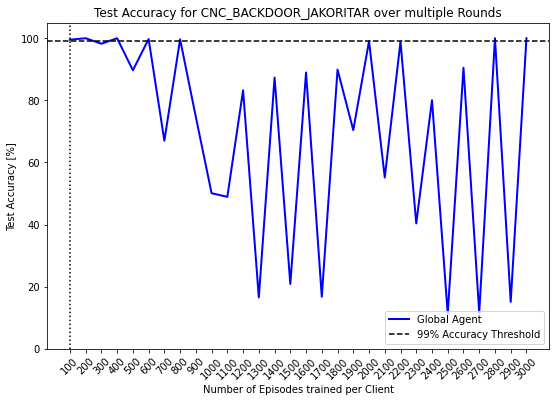

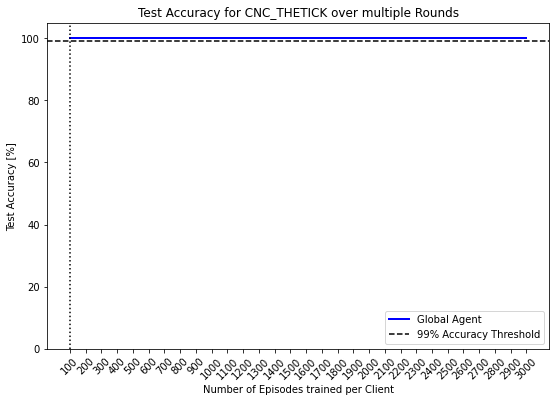

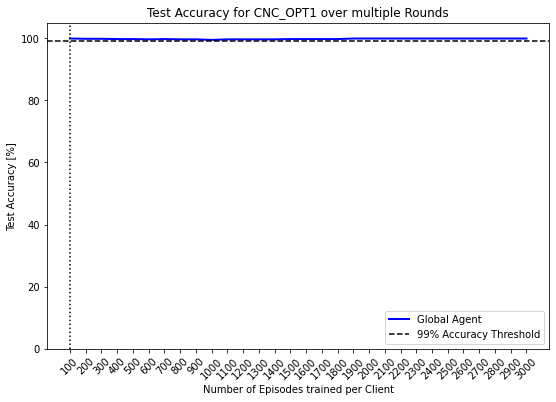

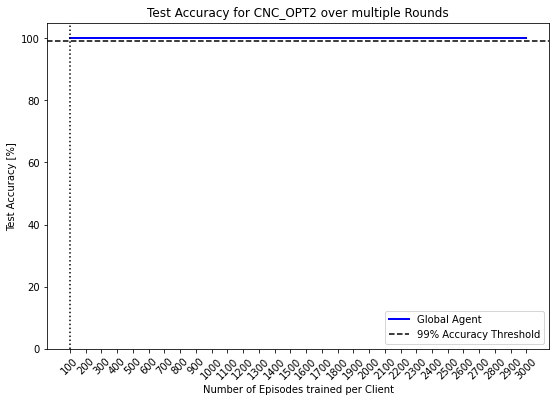

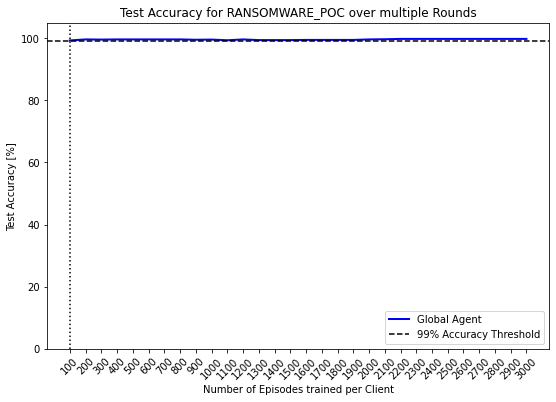

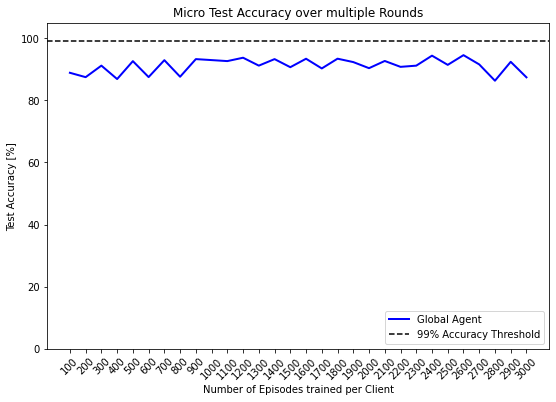

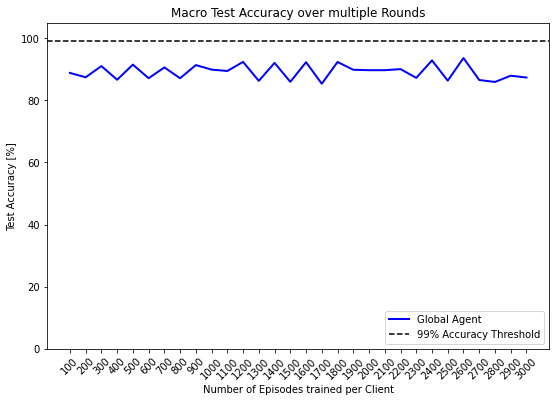

In [78]:
e1v7.show_experiment_graphs(y_threshold=99, show_individual_clients=False)